# Experiment: Varying N in top-N DDA fragmentation

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import sys
from collections import defaultdict
import seaborn as sns

In [5]:
sys.path.append('../codes')

In [6]:
from VMSfunctions.Chemicals import *
from VMSfunctions.Chromatograms import *
from VMSfunctions.MassSpec import *
from VMSfunctions.Controller import *
from VMSfunctions.Common import *
from VMSfunctions.DataGenerator import *
from VMSfunctions.Noise import *

### Useful functions

Performance is calculated by precision, recall and the mean square error of intensity when the fragmentation event occur to the maximum intensity of the chromatographic peak.

In [7]:
def get_key(chem):
    # turn a chem into (mz, rt, intensity) for equal comparison
    return (tuple(chem.isotopes), chem.rt, chem.max_intensity)

def get_frag_events(controller, ms_level):
    # get the fragmentation events for all chemicals for an ms level
    filtered_frag_events = list(filter(lambda x: x.ms_level == ms_level, controller.mass_spec.fragmentation_events))
    chem_to_frag_events = defaultdict(list)
    for frag_event in filtered_frag_events:
        key = get_key(frag_event.chem)
        chem_to_frag_events[key].append(frag_event)
    return dict(chem_to_frag_events)

def count_frag_events(key, chem_to_frag_events):
    # count how many good and bad fragmentation events for each chemical (key)
    frag_events = chem_to_frag_events[key]
    good_count = 0
    bad_count = 0
    for frag_event in frag_events:
        chem = frag_event.chem
        rt_match = chem.chromatogram._rt_match(frag_event.query_rt - chem.rt)
        if rt_match:
            good_count += 1
        else:
            bad_count += 1
    return good_count, bad_count

def get_chem_frag_counts(chem_list, chem_to_frag_events):
    # get the count of good/bad fragmentation events for all chemicals in chem_list
    results = {}
    for i in range(len(chem_list)):
        chem = chem_list[i]
        key = get_key(chem)
        try:
            good_count, bad_count = count_frag_events(key, chem_to_frag_events)
        except KeyError:
            good_count = 0
            bad_count = 0
        results[chem] = {
            'good': good_count, 
            'bad': bad_count
        }
    return results

In [8]:
def compute_performance(controller, dataset):
    ms_level = 2
    chem_to_frag_events = get_frag_events(controller, ms_level)
    positives = list(filter(lambda x: x.type == 'data', dataset))
    negatives = list(filter(lambda x: x.type == 'noise', dataset))
    positives_count = get_chem_frag_counts(positives, chem_to_frag_events)
    negatives_count = get_chem_frag_counts(negatives, chem_to_frag_events)    

    # count the following:
    # true positive = is an xcms peak (positive) and is fragmented within the chemical's elution time
    # false positive = is not an xcms peak (negative) and is fragmented within the chemical's elution time
    # false negative = is an xcms peak (positive) and is not fragmented within the chemical's elution time
    tp = len([chem for chem in positives if positives_count[chem]['good'] > 0])
    fp = len([chem for chem in negatives if negatives_count[chem]['good'] > 0])
    fn = len([chem for chem in positives if positives_count[chem]['good'] == 0])

    prec = tp / (tp + fp)
    rec = tp / (tp + fn)
    f1 = ( 2 * prec * rec) / (prec + rec)
    prec, rec, f1
    return tp, fp, fn, prec, rec, f1

In [9]:
def load_controller(results_dir, N, rt_tol):
    analysis_name = 'experiment_N_%d_rttol_%d' % (N, rt_tol)    
    pickle_in = '%s/%s.p' % (results_dir, analysis_name) 
    print('Loading %s' % analysis_name)                    
    try:
        controller = load_obj(pickle_in)
    except FileNotFoundError:
        controller = None
    return controller

def load_controllers(results_dir, Ns, rt_tols):
    controllers = []
    for N in Ns:
        for rt_tol in rt_tols:
            controller = load_controller(results_dir, N, rt_tol)
            if controller is not None:
                controllers.append(controller)
    return controllers

### Load experiment results

In [10]:
results_dir = '../models/dda_results'

In [11]:
dataset = load_obj('%s/noisy_dataset.p' % results_dir)

### Compute performance

In [12]:
def make_plot(df, X, Y, title, ylabel):
    df.plot.line(x=X, y=Y)
    plt.title(title)
    plt.ylabel(ylabel)

In [13]:
%matplotlib inline

#### Fixed rt_tol = 15 and varying Ns

In [11]:
Ns = [1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
rt_tols = [15]

In [12]:
results = []
for N in Ns:
    for rt_tol in rt_tols:
        controller = load_controller(results_dir, N, rt_tol)
        if controller is not None:
            tp, fp, fn, prec, rec, f1 = compute_performance(controller, dataset)      
            print('N=%d rt_tol=%d tp=%d fp=%d fn=%d prec=%.3f rec=%.3f f1=%.3f' % (N, rt_tol, tp, fp, fn, prec, rec, f1))
            res = (N, rt_tol, tp, fp, fn, prec, rec, f1)    
            results.append(res)            

Loading experiment_N_1_rttol_15
N=1 rt_tol=15 tp=4366 fp=3363 fn=5462 prec=0.565 rec=0.444 f1=0.497
Loading experiment_N_2_rttol_15
N=2 rt_tol=15 tp=4652 fp=3630 fn=5176 prec=0.562 rec=0.473 f1=0.514
Loading experiment_N_3_rttol_15
N=3 rt_tol=15 tp=4782 fp=3690 fn=5046 prec=0.564 rec=0.487 f1=0.523
Loading experiment_N_5_rttol_15
N=5 rt_tol=15 tp=4926 fp=3855 fn=4902 prec=0.561 rec=0.501 f1=0.529
Loading experiment_N_10_rttol_15
N=10 rt_tol=15 tp=5118 fp=3996 fn=4710 prec=0.562 rec=0.521 f1=0.540
Loading experiment_N_15_rttol_15
N=15 rt_tol=15 tp=5188 fp=4050 fn=4640 prec=0.562 rec=0.528 f1=0.544
Loading experiment_N_20_rttol_15
N=20 rt_tol=15 tp=5188 fp=4057 fn=4640 prec=0.561 rec=0.528 f1=0.544
Loading experiment_N_25_rttol_15
N=25 rt_tol=15 tp=5193 fp=4090 fn=4635 prec=0.559 rec=0.528 f1=0.543
Loading experiment_N_30_rttol_15
N=30 rt_tol=15 tp=5191 fp=4111 fn=4637 prec=0.558 rec=0.528 f1=0.543
Loading experiment_N_35_rttol_15
N=35 rt_tol=15 tp=5186 fp=4088 fn=4642 prec=0.559 rec=0.5

In [ ]:
df = pd.DataFrame(results, columns=['N', 'rt_tol', 'TP', 'FP', 'FN', 'Prec', 'Rec', 'F1'])

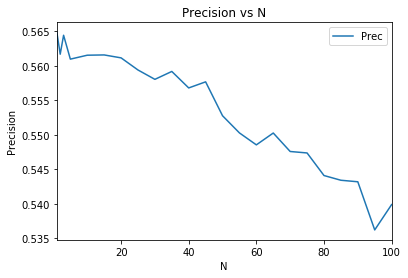

In [17]:
make_plot(df, 'N', ['Prec'], 'Precision vs N', 'Precision')

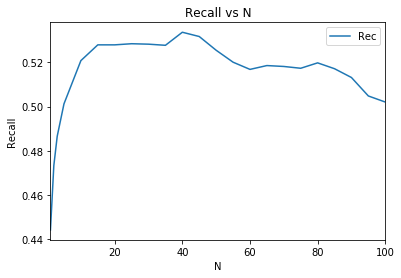

In [19]:
make_plot(df, 'N', ['Rec'], 'Recall vs N', 'Recall')

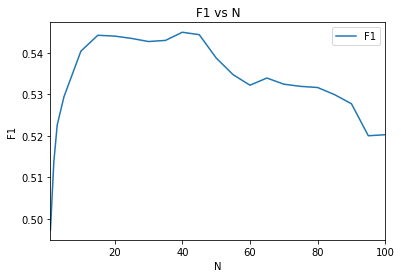

In [20]:
make_plot(df, 'N', ['F1'], 'F1 vs N', 'F1')

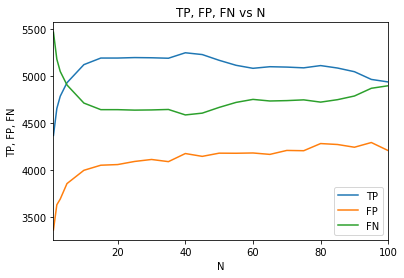

In [22]:
make_plot(df, 'N', ['TP', 'FP', 'FN'], 'TP, FP, FN vs N', 'TP, FP, FN')

In [23]:
df

,N,rt_tol,TP,FP,FN,Prec,Rec,F1
0,1,15,4366,3363,5462,0.564885,0.444241,0.497351
1,2,15,4652,3630,5176,0.561700,0.473341,0.513749
2,3,15,4782,3690,5046,0.564448,0.486569,0.522623
3,5,15,4926,3855,4902,0.560984,0.501221,0.529421
4,10,15,5118,3996,4710,0.561554,0.520757,0.540386
5,15,15,5188,4050,4640,0.561593,0.527880,0.544215
6,20,15,5188,4057,4640,0.561168,0.527880,0.544015
7,25,15,5193,4090,4635,0.559410,0.528388,0.543457
8,30,15,5191,4111,4637,0.558052,0.528185,0.542708
9,35,15,5186,4088,4642,0.559198,0.527676,0.542980


#### Fixed N = 10 and varying rt_tols

In [12]:
Ns = [10]
rt_tols = list(range(15, 301, 15))

In [13]:
results = []
for N in Ns:
    for rt_tol in rt_tols:
        controller = load_controller(results_dir, N, rt_tol)
        if controller is not None:
            tp, fp, fn, prec, rec, f1 = compute_performance(controller, dataset)      
            print('N=%d rt_tol=%d tp=%d fp=%d fn=%d prec=%.3f rec=%.3f f1=%.3f' % (N, rt_tol, tp, fp, fn, prec, rec, f1))
            res = (N, rt_tol, tp, fp, fn, prec, rec, f1)    
            results.append(res)            

Loading experiment_N_10_rttol_15
N=10 rt_tol=15 tp=5118 fp=3996 fn=4710 prec=0.562 rec=0.521 f1=0.540
Loading experiment_N_10_rttol_30
N=10 rt_tol=30 tp=5218 fp=3914 fn=4610 prec=0.571 rec=0.531 f1=0.550
Loading experiment_N_10_rttol_45
N=10 rt_tol=45 tp=5131 fp=3782 fn=4697 prec=0.576 rec=0.522 f1=0.548
Loading experiment_N_10_rttol_60
N=10 rt_tol=60 tp=5006 fp=3646 fn=4822 prec=0.579 rec=0.509 f1=0.542
Loading experiment_N_10_rttol_75
N=10 rt_tol=75 tp=4901 fp=3497 fn=4927 prec=0.584 rec=0.499 f1=0.538
Loading experiment_N_10_rttol_90
N=10 rt_tol=90 tp=4905 fp=3529 fn=4923 prec=0.582 rec=0.499 f1=0.537
Loading experiment_N_10_rttol_105
N=10 rt_tol=105 tp=4748 fp=3393 fn=5080 prec=0.583 rec=0.483 f1=0.528
Loading experiment_N_10_rttol_120
N=10 rt_tol=120 tp=4725 fp=3306 fn=5103 prec=0.588 rec=0.481 f1=0.529
Loading experiment_N_10_rttol_135
N=10 rt_tol=135 tp=4714 fp=3308 fn=5114 prec=0.588 rec=0.480 f1=0.528
Loading experiment_N_10_rttol_150
N=10 rt_tol=150 tp=4649 fp=3208 fn=5179 pr

In [18]:
df = pd.DataFrame(results, columns=['N', 'rt_tol', 'TP', 'FP', 'FN', 'Prec', 'Rec', 'F1'])

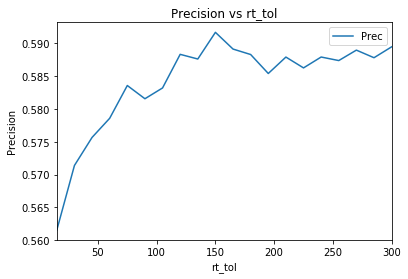

In [22]:
make_plot(df, 'rt_tol', ['Prec'], 'Precision vs rt_tol', 'Precision')

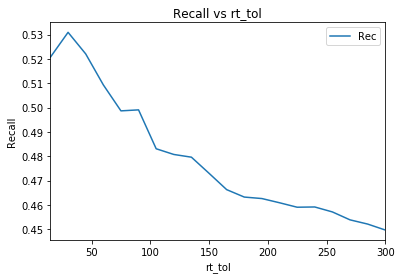

In [23]:
make_plot(df, 'rt_tol', ['Rec'], 'Recall vs rt_tol', 'Recall')

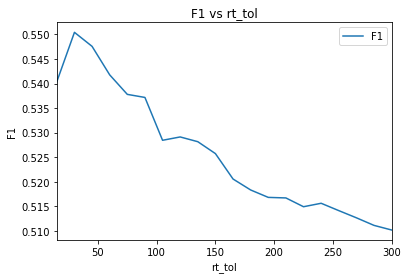

In [24]:
make_plot(df, 'rt_tol', ['F1'], 'F1 vs rt_tol', 'F1')

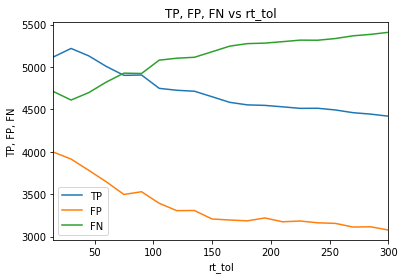

In [25]:
make_plot(df, 'rt_tol', ['TP', 'FP', 'FN'], 'TP, FP, FN vs rt_tol', 'TP, FP, FN')

In [26]:
df

,N,rt_tol,TP,FP,FN,Prec,Rec,F1
0,10,15,5118,3996,4710,0.561554,0.520757,0.540386
1,10,30,5218,3914,4610,0.571397,0.530932,0.550422
2,10,45,5131,3782,4697,0.575676,0.522080,0.547570
3,10,60,5006,3646,4822,0.578595,0.509361,0.541775
4,10,75,4901,3497,4927,0.583591,0.498677,0.537803
5,10,90,4905,3529,4923,0.581575,0.499084,0.537181
6,10,105,4748,3393,5080,0.583221,0.483109,0.528466
7,10,120,4725,3306,5103,0.588345,0.480769,0.529145
8,10,135,4714,3308,5114,0.587634,0.479650,0.528179
9,10,150,4649,3208,5179,0.591702,0.473036,0.525756


### Compute performance for varying Ns and rt_tols

In [14]:
Ns = [1, 2, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
rt_tols = list(range(15, 301, 15))

In [15]:
X, Y = np.meshgrid(Ns, rt_tols)
Z_precision = np.zeros_like(X).astype(float)
Z_recall = np.zeros_like(X).astype(float)
Z_f1 = np.zeros_like(X).astype(float)

In [17]:
for j in range(X.shape[1]):
    for i in range(X.shape[0]):    
        N = X[i, j]
        rt_tol = Y[i, j]            
        analysis_name = 'experiment_N_%d_rttol_%d' % (N, rt_tol)    
        pickle_in = '%s/%s.p' % (results_dir, analysis_name) 

        print('Loading %s' % analysis_name)                    
        try:
            controller = load_obj(pickle_in)
        except FileNotFoundError:
            controller = None

        # compute performance
        if controller is not None:
            tp, fp, fn, prec, rec, f1 = compute_performance(controller, dataset)
            print('N=%d rt_tol=%d tp=%d fp=%d fn=%d prec=%.3f rec=%.3f f1=%.3f' % (N, rt_tol, tp, fp, fn, prec, rec, f1))            
            Z_precision[i, j] = prec
            Z_recall[i, j] = rec
            Z_f1[i, j] = f1

Loading experiment_N_1_rttol_15
N=1 rt_tol=15 tp=4366 fp=3363 fn=5462 prec=0.565 rec=0.444 f1=0.497
Loading experiment_N_1_rttol_30
N=1 rt_tol=30 tp=4594 fp=3464 fn=5234 prec=0.570 rec=0.467 f1=0.514
Loading experiment_N_1_rttol_45
N=1 rt_tol=45 tp=4509 fp=3328 fn=5319 prec=0.575 rec=0.459 f1=0.511
Loading experiment_N_1_rttol_60
N=1 rt_tol=60 tp=4466 fp=3240 fn=5362 prec=0.580 rec=0.454 f1=0.509
Loading experiment_N_1_rttol_75
N=1 rt_tol=75 tp=4362 fp=3129 fn=5466 prec=0.582 rec=0.444 f1=0.504
Loading experiment_N_1_rttol_90
N=1 rt_tol=90 tp=4365 fp=3158 fn=5463 prec=0.580 rec=0.444 f1=0.503
Loading experiment_N_1_rttol_105
N=1 rt_tol=105 tp=4294 fp=3080 fn=5534 prec=0.582 rec=0.437 f1=0.499
Loading experiment_N_1_rttol_120
N=1 rt_tol=120 tp=4278 fp=2996 fn=5550 prec=0.588 rec=0.435 f1=0.500
Loading experiment_N_1_rttol_135
N=1 rt_tol=135 tp=4239 fp=2936 fn=5589 prec=0.591 rec=0.431 f1=0.499
Loading experiment_N_1_rttol_150
N=1 rt_tol=150 tp=4171 fp=2851 fn=5657 prec=0.594 rec=0.424 f

N=10 rt_tol=15 tp=5118 fp=3996 fn=4710 prec=0.562 rec=0.521 f1=0.540
Loading experiment_N_10_rttol_30
N=10 rt_tol=30 tp=5218 fp=3914 fn=4610 prec=0.571 rec=0.531 f1=0.550
Loading experiment_N_10_rttol_45
N=10 rt_tol=45 tp=5131 fp=3782 fn=4697 prec=0.576 rec=0.522 f1=0.548
Loading experiment_N_10_rttol_60
N=10 rt_tol=60 tp=5006 fp=3646 fn=4822 prec=0.579 rec=0.509 f1=0.542
Loading experiment_N_10_rttol_75
N=10 rt_tol=75 tp=4901 fp=3497 fn=4927 prec=0.584 rec=0.499 f1=0.538
Loading experiment_N_10_rttol_90
N=10 rt_tol=90 tp=4905 fp=3529 fn=4923 prec=0.582 rec=0.499 f1=0.537
Loading experiment_N_10_rttol_105
N=10 rt_tol=105 tp=4748 fp=3393 fn=5080 prec=0.583 rec=0.483 f1=0.528
Loading experiment_N_10_rttol_120
N=10 rt_tol=120 tp=4725 fp=3306 fn=5103 prec=0.588 rec=0.481 f1=0.529
Loading experiment_N_10_rttol_135
N=10 rt_tol=135 tp=4714 fp=3308 fn=5114 prec=0.588 rec=0.480 f1=0.528
Loading experiment_N_10_rttol_150
N=10 rt_tol=150 tp=4649 fp=3208 fn=5179 prec=0.592 rec=0.473 f1=0.526
Loadi

N=25 rt_tol=300 tp=4485 fp=3146 fn=5343 prec=0.588 rec=0.456 f1=0.514
Loading experiment_N_30_rttol_15
N=30 rt_tol=15 tp=5191 fp=4111 fn=4637 prec=0.558 rec=0.528 f1=0.543
Loading experiment_N_30_rttol_30
N=30 rt_tol=30 tp=5321 fp=4013 fn=4507 prec=0.570 rec=0.541 f1=0.555
Loading experiment_N_30_rttol_45
N=30 rt_tol=45 tp=5140 fp=3869 fn=4688 prec=0.571 rec=0.523 f1=0.546
Loading experiment_N_30_rttol_60
N=30 rt_tol=60 tp=5036 fp=3729 fn=4792 prec=0.575 rec=0.512 f1=0.542
Loading experiment_N_30_rttol_75
N=30 rt_tol=75 tp=4976 fp=3619 fn=4852 prec=0.579 rec=0.506 f1=0.540
Loading experiment_N_30_rttol_90
N=30 rt_tol=90 tp=4959 fp=3570 fn=4869 prec=0.581 rec=0.505 f1=0.540
Loading experiment_N_30_rttol_105
N=30 rt_tol=105 tp=4835 fp=3461 fn=4993 prec=0.583 rec=0.492 f1=0.534
Loading experiment_N_30_rttol_120
N=30 rt_tol=120 tp=4818 fp=3409 fn=5010 prec=0.586 rec=0.490 f1=0.534
Loading experiment_N_30_rttol_135
N=30 rt_tol=135 tp=4748 fp=3279 fn=5080 prec=0.592 rec=0.483 f1=0.532
Loadin

N=45 rt_tol=285 tp=4467 fp=3173 fn=5361 prec=0.585 rec=0.455 f1=0.511
Loading experiment_N_45_rttol_300
N=45 rt_tol=300 tp=4493 fp=3137 fn=5335 prec=0.589 rec=0.457 f1=0.515
Loading experiment_N_50_rttol_15
N=50 rt_tol=15 tp=5164 fp=4178 fn=4664 prec=0.553 rec=0.525 f1=0.539
Loading experiment_N_50_rttol_30
N=50 rt_tol=30 tp=5148 fp=4056 fn=4680 prec=0.559 rec=0.524 f1=0.541
Loading experiment_N_50_rttol_45
N=50 rt_tol=45 tp=5113 fp=3872 fn=4715 prec=0.569 rec=0.520 f1=0.544
Loading experiment_N_50_rttol_60
N=50 rt_tol=60 tp=5063 fp=3709 fn=4765 prec=0.577 rec=0.515 f1=0.544
Loading experiment_N_50_rttol_75
N=50 rt_tol=75 tp=4988 fp=3606 fn=4840 prec=0.580 rec=0.508 f1=0.542
Loading experiment_N_50_rttol_90
N=50 rt_tol=90 tp=4939 fp=3641 fn=4889 prec=0.576 rec=0.503 f1=0.537
Loading experiment_N_50_rttol_105
N=50 rt_tol=105 tp=4840 fp=3473 fn=4988 prec=0.582 rec=0.492 f1=0.534
Loading experiment_N_50_rttol_120
N=50 rt_tol=120 tp=4771 fp=3443 fn=5057 prec=0.581 rec=0.485 f1=0.529
Loadin

N=65 rt_tol=270 tp=4543 fp=3261 fn=5285 prec=0.582 rec=0.462 f1=0.515
Loading experiment_N_65_rttol_285
N=65 rt_tol=285 tp=4465 fp=3209 fn=5363 prec=0.582 rec=0.454 f1=0.510
Loading experiment_N_65_rttol_300
N=65 rt_tol=300 tp=4440 fp=3168 fn=5388 prec=0.584 rec=0.452 f1=0.509
Loading experiment_N_70_rttol_15
N=70 rt_tol=15 tp=5092 fp=4207 fn=4736 prec=0.548 rec=0.518 f1=0.532
Loading experiment_N_70_rttol_30
N=70 rt_tol=30 tp=5072 fp=4087 fn=4756 prec=0.554 rec=0.516 f1=0.534
Loading experiment_N_70_rttol_45
N=70 rt_tol=45 tp=5062 fp=3942 fn=4766 prec=0.562 rec=0.515 f1=0.538
Loading experiment_N_70_rttol_60
N=70 rt_tol=60 tp=4976 fp=3708 fn=4852 prec=0.573 rec=0.506 f1=0.538
Loading experiment_N_70_rttol_75
N=70 rt_tol=75 tp=4940 fp=3637 fn=4888 prec=0.576 rec=0.503 f1=0.537
Loading experiment_N_70_rttol_90
N=70 rt_tol=90 tp=4847 fp=3616 fn=4981 prec=0.573 rec=0.493 f1=0.530
Loading experiment_N_70_rttol_105
N=70 rt_tol=105 tp=4790 fp=3480 fn=5038 prec=0.579 rec=0.487 f1=0.529
Loadin

N=85 rt_tol=255 tp=4480 fp=3257 fn=5348 prec=0.579 rec=0.456 f1=0.510
Loading experiment_N_85_rttol_270
N=85 rt_tol=270 tp=4491 fp=3212 fn=5337 prec=0.583 rec=0.457 f1=0.512
Loading experiment_N_85_rttol_285
N=85 rt_tol=285 tp=4518 fp=3235 fn=5310 prec=0.583 rec=0.460 f1=0.514
Loading experiment_N_85_rttol_300
N=85 rt_tol=300 tp=4491 fp=3238 fn=5337 prec=0.581 rec=0.457 f1=0.512
Loading experiment_N_90_rttol_15
N=90 rt_tol=15 tp=5043 fp=4241 fn=4785 prec=0.543 rec=0.513 f1=0.528
Loading experiment_N_90_rttol_30
N=90 rt_tol=30 tp=4970 fp=4110 fn=4858 prec=0.547 rec=0.506 f1=0.526
Loading experiment_N_90_rttol_45
N=90 rt_tol=45 tp=4977 fp=3893 fn=4851 prec=0.561 rec=0.506 f1=0.532
Loading experiment_N_90_rttol_60
N=90 rt_tol=60 tp=4869 fp=3735 fn=4959 prec=0.566 rec=0.495 f1=0.528
Loading experiment_N_90_rttol_75
N=90 rt_tol=75 tp=4891 fp=3683 fn=4937 prec=0.570 rec=0.498 f1=0.532
Loading experiment_N_90_rttol_90
N=90 rt_tol=90 tp=4844 fp=3599 fn=4984 prec=0.574 rec=0.493 f1=0.530
Loadin

### Make plot

In [18]:
plot_data = {
    'X': X,
    'Y': Y,
    'Z_precision': Z_precision,
    'Z_recall': Z_recall,
    'Z_f1': Z_f1
}

In [19]:
save_obj(plot_data, results_dir + '/plot_data.p')

In [20]:
def make_plot(X, Y, Z, xlabel, ylabel, zlabel, title):
    # Plot the surface.
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    # Customize the z axis.
    # ax.set_zlim(-1.01, 1.01)
    # ax.zaxis.set_major_locator(LinearLocator(10))
    # ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)    
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [21]:
%matplotlib notebook

<IPython.core.display.Javascript object>


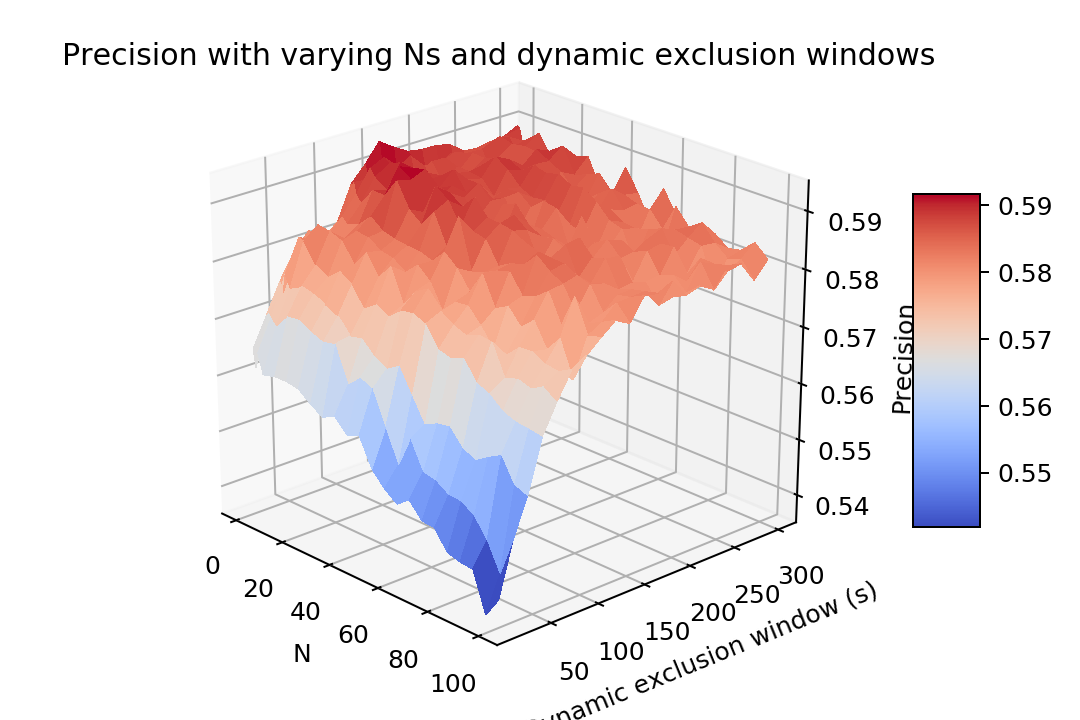

In [22]:
make_plot(X, Y, Z_precision, 'N', 'Dynamic exclusion window (s)', 'Precision', 'Precision with varying Ns and dynamic exclusion windows')

<IPython.core.display.Javascript object>


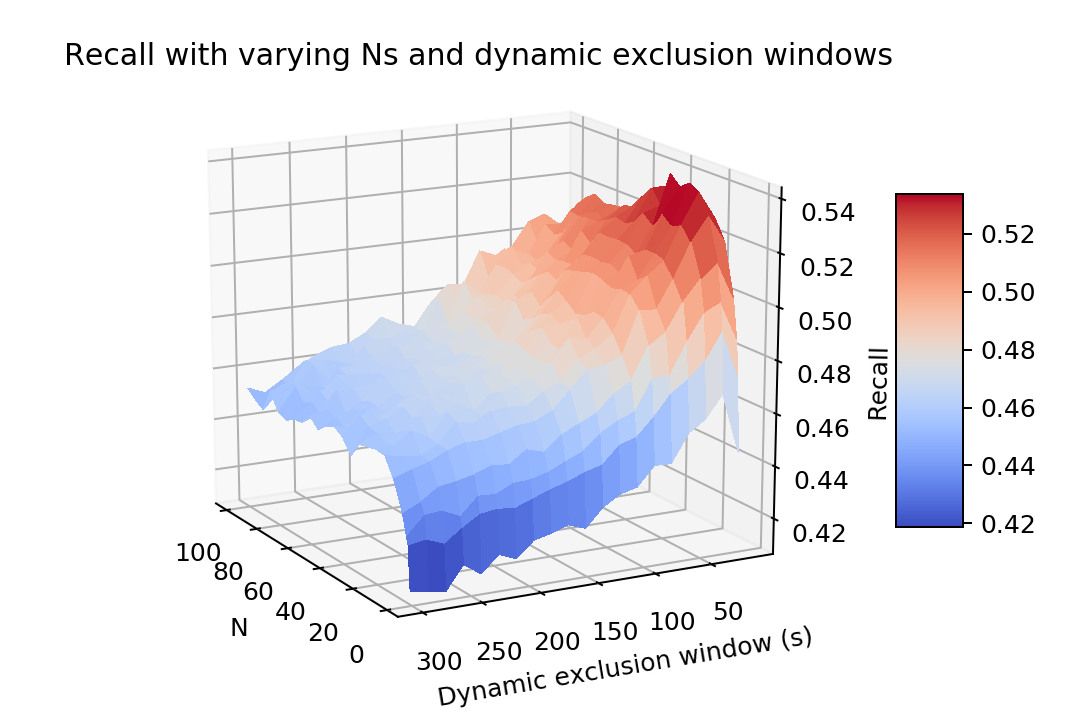

In [23]:
make_plot(X, Y, Z_recall, 'N', 'Dynamic exclusion window (s)', 'Recall', 'Recall with varying Ns and dynamic exclusion windows')

<IPython.core.display.Javascript object>


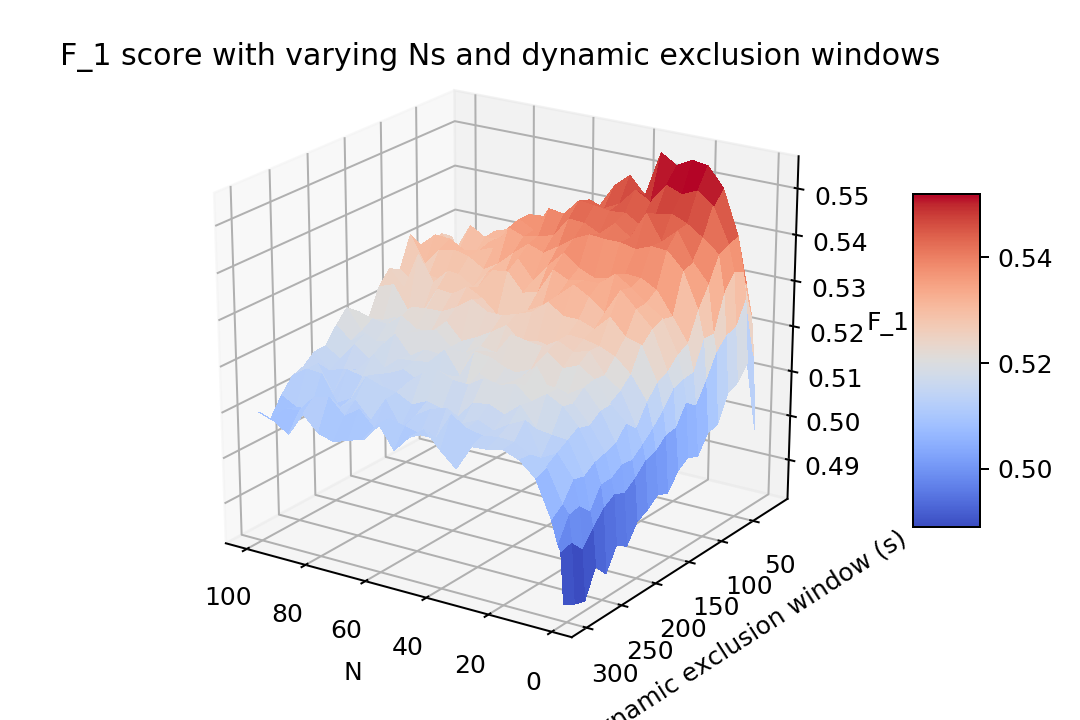

In [24]:
make_plot(X, Y, Z_f1, 'N', 'Dynamic exclusion window (s)', 'F_1', 'F_1 score with varying Ns and dynamic exclusion windows')

In [25]:
%matplotlib inline

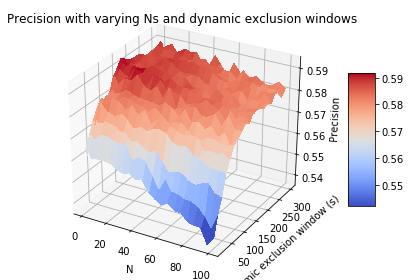

In [26]:
make_plot(X, Y, Z_precision, 'N', 'Dynamic exclusion window (s)', 'Precision', 'Precision with varying Ns and dynamic exclusion windows')

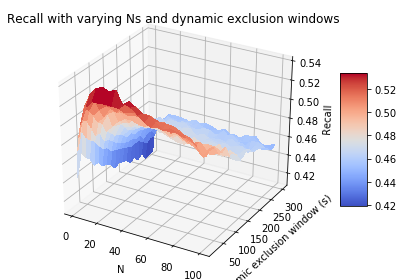

In [27]:
make_plot(X, Y, Z_recall, 'N', 'Dynamic exclusion window (s)', 'Recall', 'Recall with varying Ns and dynamic exclusion windows')

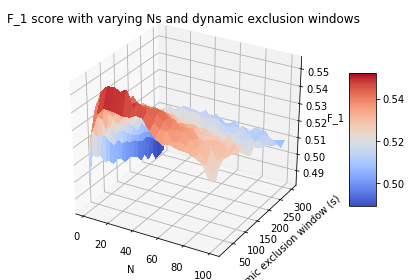

In [28]:
make_plot(X, Y, Z_f1, 'N', 'Dynamic exclusion window (s)', 'F_1', 'F_1 score with varying Ns and dynamic exclusion windows')